In [1]:
# Import modules and subroutines:
include("../subroutines/Subroutines.jl");

using ConfParser
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

md_fname = "h6_sto3g_031324%1756.hdf5"

chemical_data_list = ReadIn("../datasets/pyscf_data/"*md_fname)

conf = ConfParse("../configs/pyscf_configs/h6_octahedron_sto3g.ini")
parse_conf!(conf)
bond_lengths = parse.(Float64, retrieve(conf, "GEOMETRIES", "xyz_files"));

# Choose a bond length:
n_x = 15
println("Radius = $(bond_lengths[n_x]) Angstrom")
chemical_data = chemical_data_list[n_x]
PrintChemData(chemical_data)

Radius = 1.2 Angstrom
Molecule name: h6
Basis set: sto3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/1.2.xyz
RHF energy: -2.4528594210037307
FCI energy: -2.7984095588136295
3.10.9


In [16]:
e_corr = chemical_data.e_rhf - chemical_data.e_fci

0.34555013780989885

In [14]:
(-2.567475e+00-chemical_data.e_fci)

0.23093455881362956

In [17]:
(e_corr-0.23093455881362956)/e_corr * 100

33.169015565354506

In [45]:
(e_corr-0.00109)/e_corr * 100

99.68456097083092

In [9]:
h_1norm = norm(chemical_data.h1e, 1) + norm(chemical_data.h2e, 1)

46.94550499258082

In [46]:
function nshots(h_1norm, delta)
    return h_1norm^2/delta^2
end

nshots(h_1norm, 1e-5)

2.203880439008431e13

In [50]:
nshots(h_1norm, 1e-9) * 12285

2.7074671193218574e25

In [47]:
(nshots(h_1norm, 1e-4) + nshots(1, 1e-5))* 279488

6.439069361375884e16

In [3]:
h_2norm = sqrt(norm(chemical_data.h1e, 2)^2 + norm(chemical_data.h2e, 2)^2)

5.249228495027911

In [6]:
NumShots(1e-5, chemical_data)

2.20388043900843e13

In [7]:
NumShots(1e-9, chemical_data)

2.2038804390084307e21

In [8]:
CountStrings(chemical_data)

(11024, 2.7426723149230443)

In [9]:
sqrt(CountStrings(chemical_data)[2])

1.6561015412477111

In [2]:
# Count Pauli strings in the Hamiltonian:
function CountCNOTuCCSD(N, N_occ) # Uses spatial orbitals
    
    count = 0
    depth = 0
    
    # Count one-body terms:
    for p=(N_occ+1):N, q=1:N_occ
            
        # Two spin values
        nterm = 2
        # Descending and ascending staircase of CNOTs
        n_sf = 2*(p-q) + 1
        
        count += nterm*(2*n_sf -1)
        
        if n_sf == 2
            depth += nterm*3
        else
            depth += nterm*(maximum([5, 2*n_sf-3]))
        end
            
    end
    
    # Count two-body terms:
    for p=1:(N_occ+1):N, q=p:N, r=1:N_occ, s=r:N_occ
            
        # Two opposite-spin terms
        nterm = 2

        # Two same-spin terms if p!=q and r != s
        if p != q && r != s
            nterm += 2
        end

        # Descending and ascending staircase of CNOTs
        n_df = 2*(q-p) + 2*(s-r) + 2 # Different spin combinations should average out here

        # Total CNOTs per term:
        count += nterm*(2*n_df+5)
        
        if n_df ==4
            depth += nterm*(11 + 11) # CNOT depth plus single-qubit layers
        else
            depth += nterm*(maximum([13,2*n_df-1]) + 11)
        end
            
    end
    
    return count, depth
    
end

CountCNOTuCCSD (generic function with 1 method)

In [3]:
function CountCNOTTNQE(Nq, D)
    return Nq^2 + (16*D-1)*Nq - 16*D
end

CountCNOTTNQE (generic function with 1 method)

In [3]:
CountCNOTuCCSD(6, 3)

(3022, 3902)

In [71]:
CountCNOTTNQE(12, 6)

1188

In [4]:
nH_vec = (collect(0:11) .* 4) .+ 6

D_vec = [10,30,100]

nCNOT_uCCSD_vec = []
nCNOT_TNQE_vec = []

for nH in nH_vec
    
    push!(nCNOT_uCCSD_vec, CountCNOTuCCSD(nH,Int(nH/2))[1])
    
    nCNOT_TNQE = []
    
    for D in D_vec
    
        push!(nCNOT_TNQE, CountCNOTTNQE(2*nH,D))
        
    end
    
    push!(nCNOT_TNQE_vec, nCNOT_TNQE)
    
end

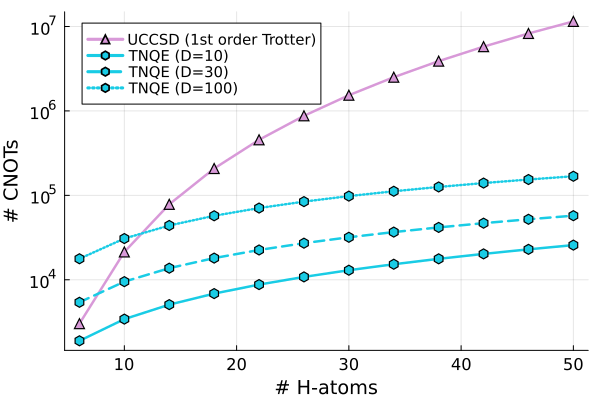

"/home/oskar/Documents/TNQE/TNQE-Julia/plots/cnot_comp_uccsd_tnqe.pdf"

In [5]:
plt1 = plot(
    [],
    [],
    xlabel="# H-atoms", 
    ylabel="# CNOTs", 
    #title="Octahedral H6; STO-3G; 1.2A; m=3", 
    gridlinewidth=1.0,
    gridalpha=0.1,
    yaxis=:log10,
    yticks=[10^3,10^4,10^5,10^6,10^7],
    xguidefontsize=13,
    yguidefontsize=13,
    xtickfontsize=11,
    ytickfontsize=11,
    legendfontsize=10,
    primary=false
)

lw=2.5

plot!(
    nH_vec, 
    [nCNOT_uCCSD_vec[n] for n=1:length(nH_vec)],
    markershape=:utriangle, 
    markersize=5, 
    markerstrokewidth=1.5,
    lw=lw, 
    color=RGB(0.85,0.6,0.85),
    label="UCCSD (1st order Trotter)"
)

plot!(
    nH_vec, 
    [nCNOT_TNQE_vec[n][1] for n=1:length(nH_vec)], 
    markershape=:hexagon, 
    markersize=5.0, 
    markerstrokewidth=1.5,
    lw=lw, 
    ls=:solid,
    color=RGB(0.1,0.8,0.9),
    label="TNQE (D=10)"
)

plot!(
    nH_vec, 
    [nCNOT_TNQE_vec[n][2] for n=1:length(nH_vec)], 
    markershape=:hexagon, 
    markersize=5.0, 
    markerstrokewidth=1.5,
    lw=lw, 
    ls=:dash,
    color=RGB(0.1,0.8,0.9),
    label="TNQE (D=30)"
)

plot!(
    nH_vec, 
    [nCNOT_TNQE_vec[n][3] for n=1:length(nH_vec)], 
    markershape=:hexagon, 
    markersize=5.0, 
    markerstrokewidth=1.5,
    lw=lw, 
    ls=:dot,
    color=RGB(0.1,0.8,0.9),
    label="TNQE (D=100)"
)

display(plt1)
savefig(plt1, "../plots/cnot_comp_uccsd_tnqe.pdf")

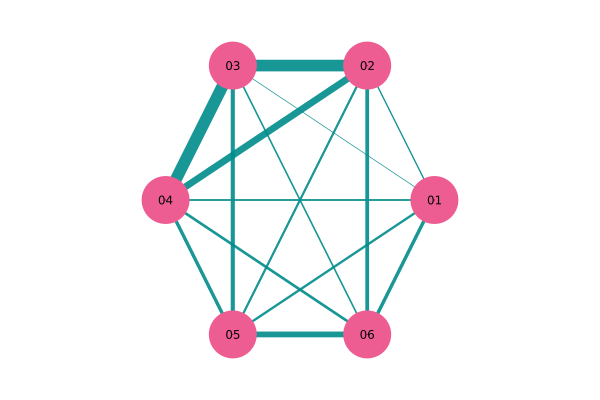

Quasi-optimal ordering: [1, 6, 5, 4, 3, 2]


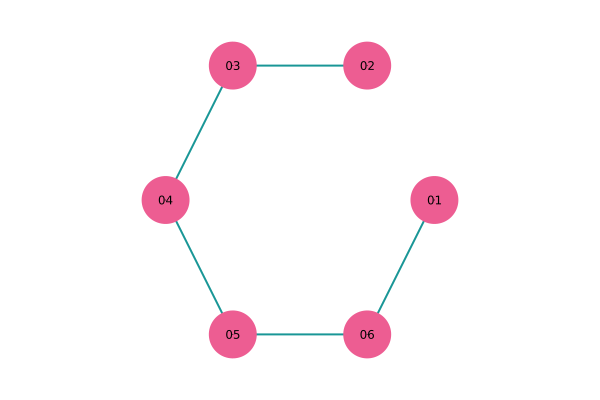

In [10]:
# Visualize the mutual information and calculate a "quasi-optimal" ordering:
fci_array = FCIArray(chemical_data)
fci_mps = MPS(fci_array, siteinds("Electron", chemical_data.N_spt), cutoff=1e-16, maxdim=2^16);

S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)
OrbitalGraphPlot(Ipq, multiplier=2e1)

gp = GeomParameters(
    maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=0.8
)

opt_ord = InfDistAnnealing(
    Ipq, 
    1, 
    gp,
    verbose=true
)[1]

println("Quasi-optimal ordering: $(opt_ord)")
OrbitalGraphPlot(GraphMat(opt_ord, directed=false), multiplier=2.0)

In [16]:
# The optimization parameters:
op1 = OptimParameters(
    maxiter=1, 
    numloop=1,  
    thresh="projection",
    eps=1e-12,
    sd_thresh="projection", 
    sd_eps=1.0e-12,
    delta=[1e-6,1e-7], # QPU noise
    noise=[0.0], # DMRG "noise" term
    sd_method="triple_geneig",
    sd_dtol=5e-3,
    sd_etol=1e-3
)


chi = 4
M_max = 4

#delta_list = vcat([1e-7,1e-7],[1e-10 for k=1:M_max])
#noise_list = vcat([],[1e-10 for k=1:M_max])
#etol_list = [1e-3 for k=1:M_max]
delta_list = [1e-5,1e-5,1e-5,1e-5,1e-5,1e-5]
noise_list = [1e-10,1e-10,1e-10,1e-10,1e-12,1e-12]
etol_list = [2e-3,1e-3,5e-4,2e-4,1e-4,5e-5]

6-element Vector{Float64}:
 0.002
 0.001
 0.0005
 0.0002
 0.0001
 5.0e-5

In [17]:
# Do a random opt_ord:
#opt_ord = randperm(chemical_data.N_spt)

tnqe0 = GenSubspace(
    chemical_data, 
    M=1, 
    mps_maxdim=chi, 
    ham_tol=1e-15,
    perm_tol=1e-15,
    thresh="projection", 
    init_ord = deepcopy(opt_ord),
    eps=1e-12, 
    sweep_num=20, 
    sweep_noise=(1e-2,1e-3,1e-4),
    dmrg_init=true,
    ovlp_opt=true,
    ovlp_weight=2.0,
    verbose=true
);


Generating Hamiltonian MPO:
Done!


Generating Hamiltonian sparse matrix:
Done!


Generating states:
Progress: [1/1] 
Done!

Minimum eigenvalue: -7.0724863030792715
Condition number: 1.0
FCI energy: -2.7984095588136295
Final energy estimate: -2.6691668465201133
Best single ref. estimate: -2.669166846520117
Error: 0.12924271229351625
BSRfE: 0.1292427122935127
Improvement: -3.552713678800501e-15
Percentage error reduction: -2.7488696389566784e-12
Eigenvalue condition numbers: [0.14]
Percent correlation energy with single-geometry DMRG: 62.59798560271032
Percent correlation energy with multi-geometry TNQE: 62.597985602709294


In [44]:
#rotypes = ["none","none","none"]
#rotypes = ["fswap","fswap","fswap"]
rotypes = ["fswap","fswap","givens"]


tnqe3_evec_full = []
tnqe3_evec = []
tnqe3_pvec = []
tnqe3_cvec = []

# Do a random opt_ord:
#opt_ord = randperm(chemical_data.N_spt)

tnqe3 = deepcopy(tnqe0)

push!(tnqe3_evec, tnqe3.E[1])
push!(tnqe3_evec_full, tnqe3.E[1])
push!(tnqe3_pvec, CountNonZeros(tnqe3.phi_list))

tot_calls = 0

for k=1:M_max-1
    
    op1.delta = [10*delta_list[k],delta_list[k]]
    op1.noise = [noise_list[k]]
    op1.sd_etol = etol_list[k]
    
    AddStates!(
        tnqe3;
        M_new=1,
        G_init="last",
        dmrg_init=(k==1),
        ovlp_opt=true,
        ovlp_weight=2.0,
        verbose=false
    )
    
    # Permute so new states are at the front:
    perm = circshift(collect(1:tnqe3.mparams.M), 1)
    
    ShuffleStates!(tnqe3, perm=perm, no_rev=true)
    
    println("\n$(tnqe3.mparams.M) states:\n")
    
    for l=1:4
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=vcat([2], [0 for i=2:tnqe3.mparams.M]),
            rotype=rotypes[1],
            jperm=vcat([1], shuffle(2:tnqe3.mparams.M)),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        
    end
    
    for l=1:6
        
        perm = randperm(tnqe3.mparams.M)
        ShuffleStates!(tnqe3, perm=perm, no_rev=true)
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=[2 for i=1:tnqe3.mparams.M],
            rotype=rotypes[2],
            jperm=collect(1:tnqe3.mparams.M),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        ShuffleStates!(tnqe3, perm=invperm(perm), no_rev=true)
        
        perm = randperm(tnqe3.mparams.M)
        ShuffleStates!(tnqe3, perm=perm, no_rev=true)
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=[2 for i=1:tnqe3.mparams.M],
            rotype=rotypes[3],
            jperm=collect(1:tnqe3.mparams.M),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        ShuffleStates!(tnqe3, perm=invperm(perm), no_rev=true)
        
    end
    
    push!(tnqe3_evec, tnqe3.E[1])
    push!(tnqe3_pvec, CountNonZeros(tnqe3.phi_list))
    push!(tnqe3_cvec, tot_calls)
    println("\nTotal QPU calls = $(tot_calls)\n")
    
end

"""
nomps_evec = deepcopy(tnqe3_evec)
nomps_evec_full = deepcopy(tnqe3_evec_full)
nomps_pvec = deepcopy(tnqe3_pvec)

fswap_evec = deepcopy(tnqe3_evec)
fswap_evec_full = deepcopy(tnqe3_evec_full)
fswap_pvec = deepcopy(tnqe3_pvec)

"""
givens_evec3 = deepcopy(tnqe3_evec)
givens_evec3_full = deepcopy(tnqe3_evec_full)
givens_pvec3 = deepcopy(tnqe3_pvec)
givens_cvec3 = deepcopy(tnqe3_cvec)



2 states:

Loop: (1/1); Bond: 5/5; #swaps: 1; E_min = -7.08592; Delta = 0.11581; kappa_full = 1.23; kappa = 1.01     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 2; E_min = -7.1493; Delta = 0.05243; kappa_full = 1.42; kappa = 1.06      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 2; E_min = -7.15674; Delta = 0.04499; kappa_full = 13.6; kappa = 6.13     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.16032; Delta = 0.04141; kappa_full = 12.9; kappa = 6.07     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 1; E_min = -7.16936; Delta = 0.03237; kappa_full = 58.2; kappa = 2.6      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 10; E_min = -7.17444; Delta = 0.02729; kappa_full = 27.1; kappa = 2.24     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 2; E_min = -7.17458; Delta = 0.02715; kappa_full = 28.7; kappa = 2.05      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 10; E_min = -7.17507; Delta = 0.02666; kappa_full = 30.3; kappa = 1.64     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 1; E_min = -7.17771; Delta = 0.02402; kap

3-element Vector{Any}:
  33804
 121318
 288505

In [56]:
# Estimating the gate cost of a one-hot state:
psi = deepcopy(tnqe3.phi_list[1])

p=5
l=3

orthogonalize!(psi, p)

T = psi[p] * psi[p+1]
ohts = OneHotTensors(T)

U,S,V = svd(ohts[l], commoninds(T, psi[p]))

psi_oht = deepcopy(psi)
psi_oht[p] = U
psi_oht[p+1] = S*V

orthogonalize!(psi_oht, 1)

psi_d2 = dConvert(psi_oht);

#truncate!(psi_d2, mindim=2)

#println(linkdims(psi_d2))

"""
for D=1:15
    dt = GenerateDisentanglers(psi_d2; depth=1, verbose=true)

    dt2 = ReOptimizeDisentanglers(psi_d2, dt; loops=10, verbose=false, cutoff=1e-8)

    psi_d2 = ApplyDisentanglers(psi_d2, dt2; cutoff=1e-8)
end
"""

#psi_d2

dt = GenerateDisentanglers(psi_d2; depth=6, verbose=true)
dt2 = ReOptimizeDisentanglers(psi_d2, dt; loops=20, verbose=true, cutoff=1e-14);

abs(1-abs(BitstringOverlap(ApplyDisentanglers(psi_d2,dt2,cutoff=1e-14), [1 for k=1:length(psi_d2)]))^2)

Starting disentangler loop!
Initial bond dimension: 5
----------------------------------
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Layer 1 of 6 generated!
Bitstring fidelity: 0.8448865543507672
Maxlinkdim: 6
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Layer 2 of 6 generated!
Bitstring fidelity: 0.9300856232324046
Maxlinkdim: 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Layer 3 of 6 generated!
Bitstring fidelity: 0.9786262871857935
Maxlinkdim: 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Layer 4 of 6 generated!
Bitstring fidelity: 0.9948472221096486
Maxlinkdim: 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Layer 5 of 6 generated!
Bitstring fidelity: 0.9976404736818799
Maxlinkdim: 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Layer 6 of 6 generated!
Bitstring fidelity: 0.9988573436405088
Maxlinkdim: 4
----------------------------------
Done!

Commencing loop 1 of 20:

Layer 23 of 23 complete; bitstring fidelity = 0.99706406684917015
Loop complete!


Commencing loop 2 of 20:

Layer 23 of 23 complete; bitstring fidelity = 0.9995900154211812
Loo

LoadError: InterruptException:

In [13]:
include("../subroutines/UCCSD.jl")

# Optimize the uCCSD energy:
e_opt, x_opt, func_evals = uCCSDMinimize(chemical_data, maxiter = 100, eps_init=0.1, eps=1e-8)

-2.4528594210037244
Iter     Function value   Gradient norm 
     0    -2.452859e+00     3.236981e-01
 * time: 0.00012803077697753906
     1    -2.506494e+00     1.377578e-01
 * time: 16.321360111236572
     2    -2.526484e+00     1.462695e-01
 * time: 40.167481899261475
     3    -2.548946e+00     9.099292e-02
 * time: 67.24942898750305
     4    -2.550811e+00     4.982512e-02
 * time: 87.59073996543884
     5    -2.552435e+00     2.212948e-02
 * time: 115.35425400733948
     6    -2.554351e+00     1.331377e-02
 * time: 143.5389609336853
     7    -2.554919e+00     1.381663e-02
 * time: 160.93213391304016
     8    -2.555372e+00     1.283707e-02
 * time: 189.4845860004425
     9    -2.556056e+00     1.915868e-02
 * time: 217.85334491729736
    10    -2.557051e+00     1.028201e-02
 * time: 247.44246697425842
    11    -2.557681e+00     1.321600e-02
 * time: 278.23871994018555
    12    -2.557994e+00     8.684323e-03
 * time: 297.54022693634033
    13    -2.558190e+00     6.041657e-03
 

(-2.5674751487307352, [0.02966779931456856, 0.07404951859608375, 0.1278024491425592, -0.0019671235657187525, -0.00043044465189136336, -0.025329624704661685, 0.0025292522695451658, 0.012976170530411026, 0.024349555698699975, 0.05192415994374264  …  -0.13298458049829456, -1.2813037700721492, 0.034525485067189096, -0.005462315638549436, -0.009154037282265043, -0.2800734095053082, -0.06444493228629565, 0.26418737167220374, -0.04695159334739542, 0.009208974838427543], 24570)

In [24]:
2.563766e+00-2.567104e+00

-0.003337999999999841